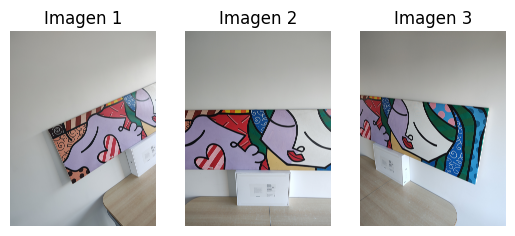

In [24]:
# --- Librerías principales ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Paths ---
IMGS_PATH = "img"  # carpeta donde pongas las fotos
imgs = [
    cv2.imread(os.path.join(IMGS_PATH, "cuadro_0.jpg")),
    cv2.imread(os.path.join(IMGS_PATH, "cuadro_1.jpg")),
    cv2.imread(os.path.join(IMGS_PATH, "cuadro_2.jpg"))
]

# --- Visualización rápida ---
for i, img in enumerate(imgs):
    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Imagen {i+1}")
    plt.axis("off")
plt.show()


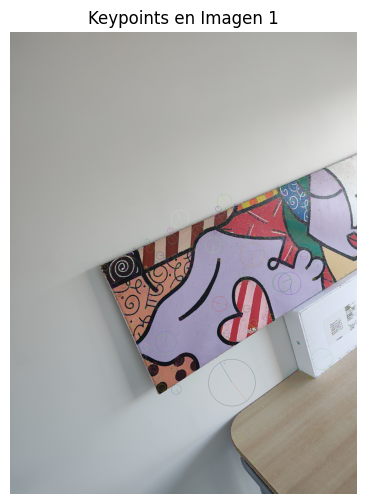

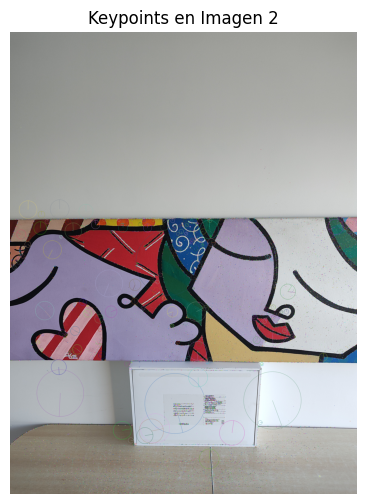

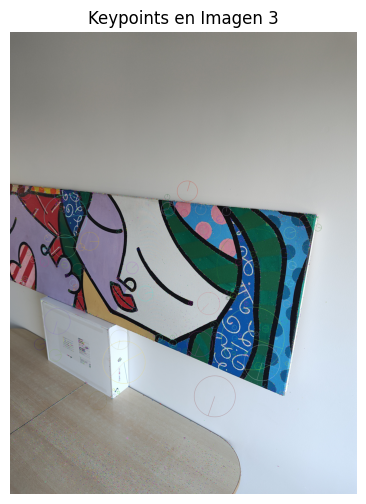

In [25]:
# --- Librerías ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


# --- Inicializar detector/descriptor SIFT ---
sift = cv2.SIFT_create()

keypoints = []
descriptors = []

for img in imgs:
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)

# --- Mostrar keypoints en cada imagen ---
for i, img in enumerate(imgs):
    img_kp = cv2.drawKeypoints(img, keypoints[i], None,
                               flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.title(f"Keypoints en Imagen {i+1}")
    plt.axis("off")
    plt.show()


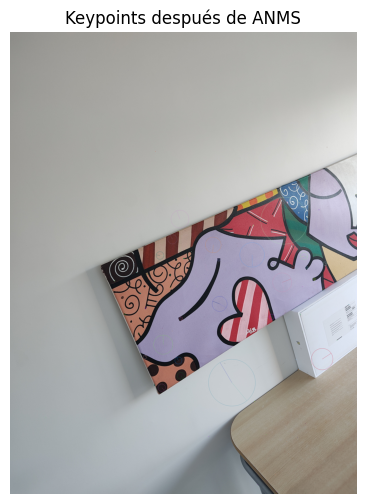

Imagen 1: Antes = 13634, Después de ANMS = 200
Imagen 2: Antes = 15150, Después de ANMS = 200
Imagen 3: Antes = 13945, Después de ANMS = 200


In [ ]:
def anms(keypoints, descriptors, N=500):
    """
    Adaptive Non-Maximal Suppression (ANMS)
    keypoints: lista de cv2.KeyPoint
    descriptors: array de descriptores asociado a esos keypoints
    N: número máximo de puntos a retener
    """
    if len(keypoints) <= N:
        return keypoints, descriptors

    # Respuesta de cada keypoint (cuánto "fuerte" es)
    responses = np.array([kp.response for kp in keypoints])

    # Inicializamos radio supresión con infinito
    radii = np.full(len(keypoints), np.inf)

    # Para cada punto calculamos la distancia mínima a otro con mayor respuesta
    for i in range(len(keypoints)):
        for j in range(len(keypoints)):
            if responses[j] > responses[i]:
                dist = (keypoints[i].pt[0] - keypoints[j].pt[0])**2 + \
                       (keypoints[i].pt[1] - keypoints[j].pt[1])**2
                if dist < radii[i]:
                    radii[i] = dist

    # Ordenamos por radio descendente
    sorted_idx = np.argsort(-radii)
    selected_idx = sorted_idx[:N]

    # Filtramos keypoints y descriptores
    keypoints_anms = [keypoints[i] for i in selected_idx]
    descriptors_anms = descriptors[selected_idx, :]

    return keypoints_anms, descriptors_anms


# --- Aplicamos ANMS a cada imagen ---
N = 200  # número de puntos a quedarnos
keypoints_anms = []
descriptors_anms = []

for kp, des in zip(keypoints, descriptors):
    kp_sel, des_sel = anms(kp, des, N)
    keypoints_anms.append(kp_sel)
    descriptors_anms.append(des_sel)


for i in range(len(keypoints)):
    print(f"Imagen {i+1}: Antes = {len(keypoints[i])}, Después de ANMS = {len(keypoints_anms[i])}")

Antes de ANMS: 13634
Después de ANMS: 200


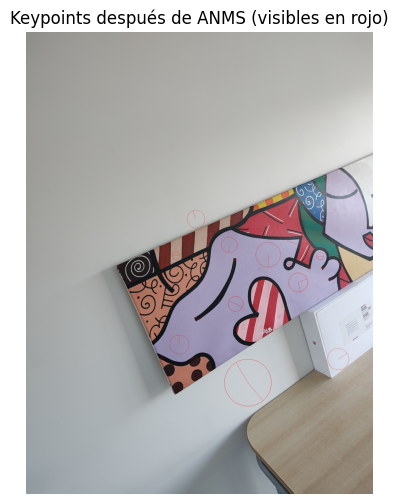

In [28]:

print("Antes de ANMS:", len(keypoints[0]))
print("Después de ANMS:", len(keypoints_anms[0]))

img_kp = cv2.drawKeypoints(imgs[0], keypoints_anms[0], None,
                           color=(0,0,255),  # rojo en BGR
                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
plt.title("Keypoints después de ANMS (visibles en rojo)")
plt.axis("off")
plt.show()

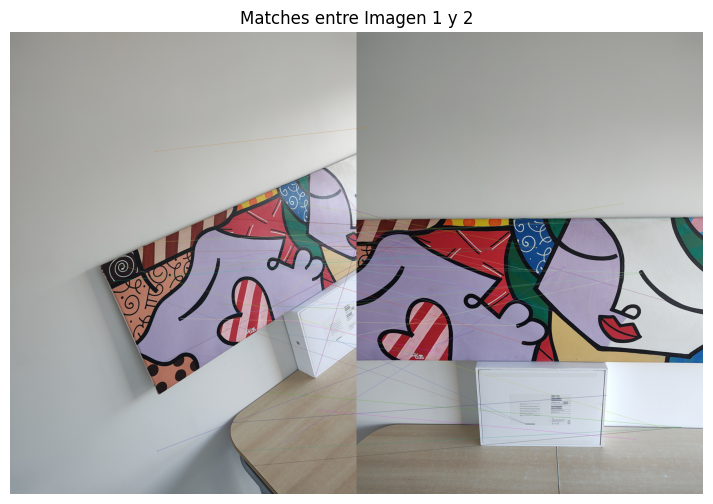

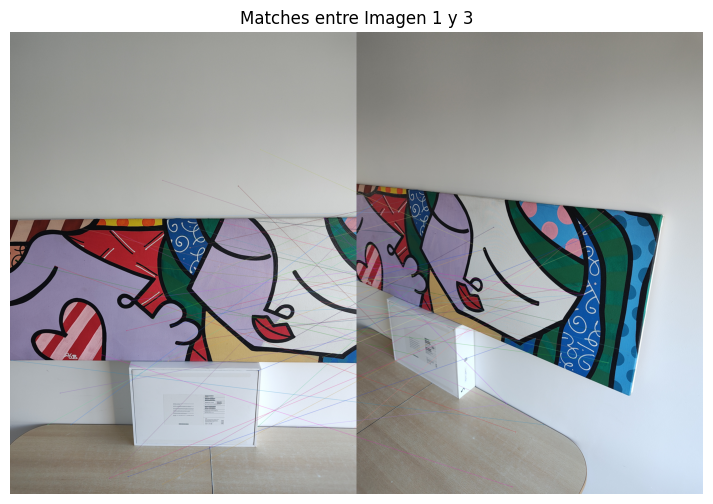

In [30]:
def match_features(des1, des2, ratio_thresh=0.9):
    """
    Matching con BFMatcher + Lowe's ratio test
    """
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    return good_matches


# --- Matching entre imagen 1 (ancla) e imagen 2 ---
matches_12 = match_features(descriptors_anms[0], descriptors_anms[1])

# --- Matching entre imagen 1 (ancla) e imagen 3 ---
matches_13 = match_features(descriptors_anms[0], descriptors_anms[2])


# --- Visualización de los matches ---
img_matches_12 = cv2.drawMatches(imgs[0], keypoints_anms[0],
                                 imgs[1], keypoints_anms[1],
                                 matches_12[:50], None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(img_matches_12, cv2.COLOR_BGR2RGB))
plt.title("Matches entre Imagen 1 y 2")
plt.axis("off")
plt.show()

img_matches_13 = cv2.drawMatches(imgs[1], keypoints_anms[1],
                                 imgs[2], keypoints_anms[2],
                                 matches_13[:50], None,
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(img_matches_13, cv2.COLOR_BGR2RGB))
plt.title("Matches entre Imagen 1 y 3")
plt.axis("off")
plt.show()
